## Verificação de Algoritmos

Neste notebook serao testadas tecnicas mais tradicionais para classificacao das mensagens. Testado um treinamento nao supervisionado usando o Spectral Clustering, e tambem um treinamento supervisionado usando alguns algoritmos classificadores.

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [22]:
import time
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [4]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['qua fud voc era asma rinit inestouleranc lacestous gluten problem visa alerg poeir canelit dor nas cost alerg calor estouss alerg dor coraca pressa baix pressa alta sinusit cit twet cad meus cach qua fud voc asma rinit inestouleranc lacestous gluten problem visa alerg poeir dor joelh dor nas cost alerg calor alerg pel dor coraca pressa baix pressa alta sinusit'
 0]
2197


### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [12]:
start = time.time()

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3), (3, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)
        y = textos[:, 1].astype(np.int).ravel()

        for metric in (
            cosine_distances,
            euclidean_distances, 
            sigmoid_kernel, 
            polynomial_kernel,
            rbf_kernel,
            # Usam apenas 1 cpu para calcular... muito lento
            # laplacian_kernel, 
            # chi2_kernel,
        ):
            for assign_labels in ["discretize", "kmeans"]:
                acc, f1 = [], []
                for _ in range(3):
                    clustering = SpectralClustering(
                        n_clusters=2,
                        eigen_solver="amg",
                        assign_labels=assign_labels,
                        affinity="precomputed_nearest_neighbors",
                        random_state=0,
                        n_jobs=-1
                    ).fit(metric(X))

                    pred = clustering.labels_
                    acc.append(round(accuracy_score(pred, y) * 100, 2))
                    f1.append(round(f1_score(pred, y) * 100, 2))
                acc, f1 = np.asarray(acc), np.asarray(f1)
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    metric.__name__,
                    assign_labels,
                    acc.mean(),
                    f1.mean(),
                ))

print(time.time() - start)

244.12336683273315


In [14]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "Metric"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Accuracy,F1
58,CountVectorizer,None,"(1, 2)",rbf_kernel,discretize,42.06,56.00
55,CountVectorizer,None,"(1, 2)",sigmoid_kernel,kmeans,46.24,49.03
57,CountVectorizer,None,"(1, 2)",polynomial_kernel,kmeans,46.24,49.03
65,CountVectorizer,None,"(1, 3)",sigmoid_kernel,kmeans,46.79,48.89
67,CountVectorizer,None,"(1, 3)",polynomial_kernel,kmeans,46.79,48.89
64,CountVectorizer,None,"(1, 3)",sigmoid_kernel,discretize,46.97,47.87
66,CountVectorizer,None,"(1, 3)",polynomial_kernel,discretize,46.97,47.87
45,CountVectorizer,None,"(1, 1)",sigmoid_kernel,kmeans,46.06,47.82
47,CountVectorizer,None,"(1, 1)",polynomial_kernel,kmeans,46.06,47.82
54,CountVectorizer,None,"(1, 2)",sigmoid_kernel,discretize,46.93,47.29


              precision    recall  f1-score   support

           0       0.63      0.09      0.15      1321
           1       0.40      0.92      0.56       876

    accuracy                           0.42      2197
   macro avg       0.52      0.51      0.36      2197
weighted avg       0.54      0.42      0.31      2197



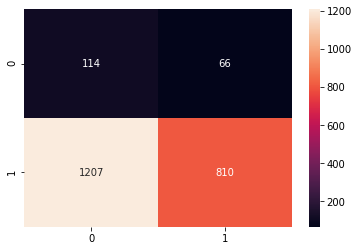

In [15]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(textos[:, 0])
# X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(rbf_kernel(X))
pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [41]:
start = time.time()

r_state = [0, 10, 50, 100, 1000]

classifiers = [
    ("LogisticRegression", LogisticRegression, {
        "max_iter":1000,
        "multi_class": "ovr",
        "n_jobs":-1
    }), 
    ("SGDClassifier", SGDClassifier, {
        "alpha": 1e-5,
        "n_jobs": -1,
        "max_iter": 5000,
        "n_iter_no_change": 100
    }), 
    ("SVC_Linear", SVC, {"kernel": "linear", "C": 5}),
    ("SVC_Linear_2", SVC, {"kernel": "linear", "C": 0.025}),
    ("SVC_RBF", SVC, {"gamma": 2, "C": 5}),
]

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        y = textos[:, 1].astype(np.int).ravel()
        
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)

        for name, Classifier, params in classifiers:
            acc , f1 = [], []
            for i in range(5):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r_state[i])
                clf = Classifier(random_state=r_state[i], **params).fit(X_train, y_train)
                pred = clf.predict(X_test)
                acc.append(round(accuracy_score(pred, y_test) * 100, 2))
                f1.append(round(f1_score(pred, y_test) * 100, 2))
            acc, f1 = np.asarray(acc), np.asarray(f1)
            validacoes.append((
                vectorizer.__class__.__name__,
                norm_name,
                ngram_range,
                name,
                round(acc.mean(), 2),
                acc.max(),
                round(f1.mean(), 2),
                f1.max()
            ))

print(time.time() - start)

155.05700016021729


In [42]:
columns = ["Vectorizer", "Scaler", "NGram", "Classifier", "Accuracy", "Acc Max.", "F1", "F1 Max."]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "NGram"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Classifier,Accuracy,Acc Max.,F1,F1 Max.
20,CountVectorizer,None,"(1, 2)",LogisticRegression,75.77,79.32,70.79,75.07
37,TfidfVectorizer,None,"(1, 2)",SVC_Linear,77.27,80.45,69.80,74.10
25,CountVectorizer,None,"(1, 3)",LogisticRegression,74.91,78.64,69.77,74.18
15,CountVectorizer,None,"(1, 1)",LogisticRegression,75.05,76.82,69.52,72.13
42,TfidfVectorizer,None,"(1, 3)",SVC_Linear,77.68,78.18,68.93,70.00
36,TfidfVectorizer,None,"(1, 2)",SGDClassifier,76.50,77.73,68.14,69.38
22,CountVectorizer,None,"(1, 2)",SVC_Linear,72.23,74.77,67.91,70.87
41,TfidfVectorizer,None,"(1, 3)",SGDClassifier,77.18,78.18,67.73,69.03
32,TfidfVectorizer,None,"(1, 1)",SVC_Linear,73.55,76.14,67.24,71.54
21,CountVectorizer,None,"(1, 2)",SGDClassifier,72.77,77.95,67.07,71.88


CrossValidation scores: [0.78125    0.76704545 0.74928775 0.74074074 0.78347578]

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       270
           1       0.75      0.65      0.70       170

    accuracy                           0.78       440
   macro avg       0.77      0.76      0.76       440
weighted avg       0.78      0.78      0.78       440



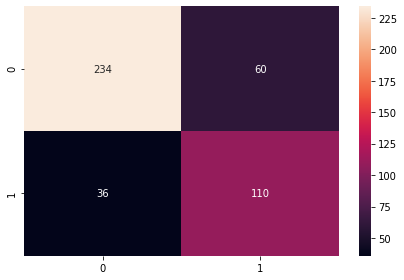

In [58]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
y = textos[:, 1].astype(np.int).ravel()

r_state = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r_state)

# clf = SGDClassifier(
#     alpha=1e-5,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=5000,
#     n_iter_no_change=100
# ).fit(X_train, y_train)

clf = SVC(kernel="linear", C=5, random_state=r_state)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"CrossValidation scores: {scores}")
print()

clf = SVC(kernel="linear", C=5, random_state=r_state).fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

### Supervised Learning : Ensemble

CrossValidation scores: [0.72727273 0.73579545 0.71225071 0.71509972 0.72364672]

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       270
           1       0.79      0.43      0.56       170

    accuracy                           0.74       440
   macro avg       0.76      0.68      0.68       440
weighted avg       0.75      0.74      0.71       440



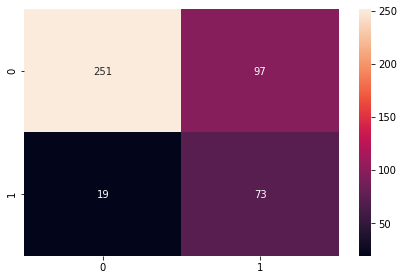

In [61]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
# X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

r_state = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r_state)

clf1 = LogisticRegression(random_state=r_state, n_jobs=-1, max_iter=1000, multi_class="ovr",)
clf2 = RandomForestClassifier(n_estimators=100, random_state=r_state)
clf3 = MultinomialNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
)

scores = cross_val_score(eclf, X_train, y_train, cv=5)
print(f"CrossValidation scores: {scores}")
print()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
).fit(X_train, y_train)
pred = eclf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()